# Anomaly Detection
Andrew Zhang(azhang42)

As the name suggests, anomaly detection is the process of detecting anomalies from data. Some uses of anomaly detection are to detect fraud from transactions or detect possible faults during manufacturing. There are many techniques for anomaly detection. Let's overview a fiew.

## Z-Score

Z-score is a simple technique. It calculates how far away a data point is from the mean according to standard deviations. If a point is very far away from the mean, it is likely considered an anomaly. The formula for Z-score is:

$$Z = \frac{X - \mu}{\sigma}$$

## Interquartile Range (IQR)

Another simple technique is IQR. If the datapoitn is in the middle 50% of the data, it is not an anomaly. If it is outside of the middle 50%, it is an anomaly. The formula for IQR is:

$$\text{IQR} = Q3 - Q1$$
$$\text{Outliers if } X < Q1 - 1.5 \times \text{IQR} \text{ or } X > Q3 + 1.5 \times \text{IQR}$$

## Machine Learning Methods.

Finally, another way to detect anomalies is to use machine learning models. One such method is Autoencoders, which try to compress and reconstruct data. If the reconstruction error is high, then it is likely an anomaly.

## Practical demonstration with credit card fraud

We will use Auto-Encoders to detect credit card fraud. The dataset is from Kaggle.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = 'creditcard.csv'  # Update this path
data = pd.read_csv(file_path)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Normalizing the 'Time' and 'Amount' columns
scaler = StandardScaler()
data['NormalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['NormalizedTime'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

# Dropping the original 'Time' and 'Amount' columns
data = data.drop(['Time', 'Amount'], axis=1)

# Separating the features and the target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Using only non-fraudulent transactions for training the autoencoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[y_train == 0].values
X_test = X_test.values
y_test = y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=256, shuffle=True)

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 14),
            nn.ReLU(),
            nn.Linear(14, 7),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(7, 14),
            nn.ReLU(),
            nn.Linear(14, num_features)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder
num_features = X_train.shape[1]
model = Autoencoder(num_features)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/andrewzhang/opt/anaconda3/envs/cs5864/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andrewzhang/opt/anaconda3/envs/cs5864/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/andrewzhang/opt/anaconda3/envs/cs5864/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/andrewzhang/opt/anaconda3/envs/cs5864/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

Text(0, 0.5, 'Frequency')

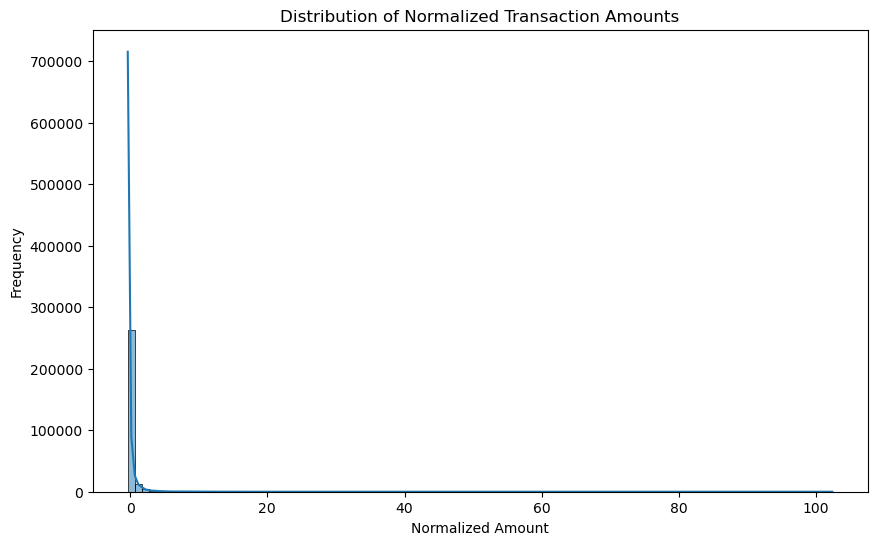

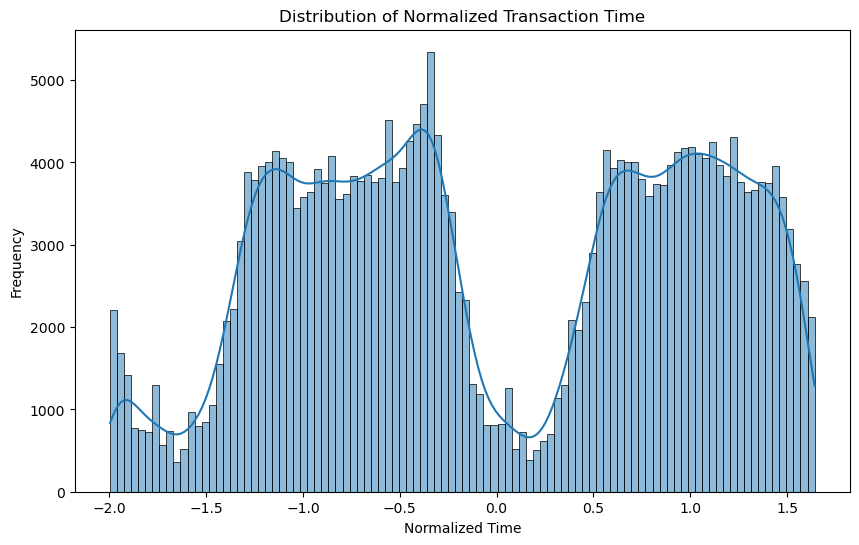

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data['NormalizedAmount'], bins=100, kde=True)
plt.title('Distribution of Normalized Transaction Amounts')
plt.xlabel('Normalized Amount')
plt.ylabel('Frequency')

# Distribution of Normalized Transaction Time
plt.figure(figsize=(10, 6))
sns.histplot(data['NormalizedTime'], bins=100, kde=True)
plt.title('Distribution of Normalized Transaction Time')
plt.xlabel('Normalized Time')
plt.ylabel('Frequency')

In [5]:
# Create data loaders
# Since this is an autoencoder, inputs are the same as the outputs (targets).
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Rest of the training code remains the same

# Training the model
epochs = 20
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print('loss:', loss.item())
        loss.backward()
        optimizer.step()


loss: 0.957414448261261
loss: 0.9983395934104919
loss: 0.8878101110458374
loss: 1.003751277923584
loss: 1.1978557109832764
loss: 0.9562521576881409
loss: 1.0343316793441772
loss: 0.9772053956985474
loss: 0.8289576172828674
loss: 0.8628119230270386
loss: 1.7636985778808594
loss: 0.8809128403663635
loss: 1.077673077583313
loss: 0.9840152859687805
loss: 0.9514206647872925
loss: 1.6147550344467163
loss: 0.9405023455619812
loss: 0.9524431824684143
loss: 0.9797568917274475
loss: 0.8967246413230896
loss: 1.1783137321472168
loss: 0.9218614101409912
loss: 1.145142912864685
loss: 1.0562845468521118
loss: 0.8700891733169556
loss: 0.9577253460884094
loss: 0.94657301902771
loss: 0.9846344590187073
loss: 0.8655980229377747
loss: 0.9693602919578552
loss: 0.9340037107467651
loss: 0.9788376092910767
loss: 0.8560813069343567
loss: 1.9265772104263306
loss: 1.975443720817566
loss: 0.7894335389137268
loss: 1.2260053157806396
loss: 0.8757785558700562
loss: 1.591881275177002
loss: 0.8082437515258789
loss: 1.